<a href="https://colab.research.google.com/github/braiso-22/Neuronal_Networks_Convolution/blob/main/consumo_electrico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# datos:https://www.kaggle.com/datasets/sagnikseal/household-power-consumption?resource=download


In [ ]:
import sys
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    # montar el drive, que es donde tenemos el dataset
    from google.colab import drive 
    drive.mount("/content/drive")
    data_dir = "/content/drive/MyDrive/Colab Notebooks/datasets/"  
    sys.path.append(data_dir)
else:
    import os
    data_dir = os.path.dirname(__file__) + "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
np.random.seed(5)

import matplotlib.pyplot as plt

import pandas as pd
import datetime

from keras.layers import Input, Dense, SimpleRNN
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
#    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    fig = plt.figure(figsize=(15,5))
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(nmuestras, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(nmuestras, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, nmuestras + 1, 0, 0.4])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, 0, 0.4])
    plt.legend(fontsize=14)

In [ ]:
df = pd.read_csv(data_dir + "Household_power_consumption.csv", sep=",", parse_dates=["datetime"], index_col="datetime")
df=df[["Global_active_power"]]
df = df.resample("D").mean()
df

,Global_active_power
datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658
...,...
2010-11-22,1.417733
2010-11-23,1.095511
2010-11-24,1.247394


In [ ]:
scaler = MinMaxScaler()
scaler.fit(df[["Global_active_power"]])
df["Global_active_power"] = scaler.transform(df[["Global_active_power"]])

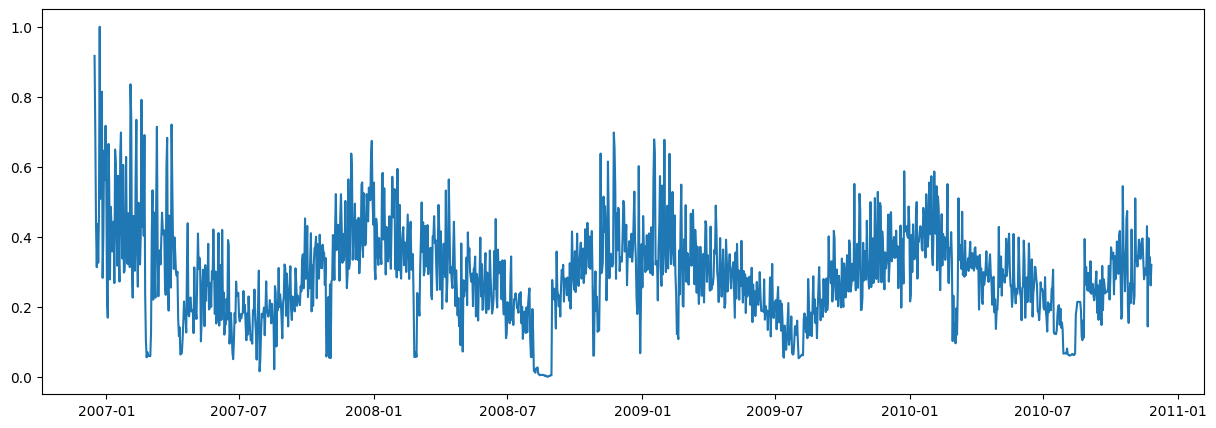

In [ ]:
fig=plt.figure(figsize=(15,5))
plt.plot(df.index, df['Global_active_power'])

In [ ]:
df_train = df.loc["20060101":"20090101"]
df_test = df.loc["20090102":"20100101"]
df_test

,Global_active_power
datetime,
2009-01-02,0.459246
2009-01-03,0.367713
2009-01-04,0.373571
2009-01-05,0.299287
2009-01-06,0.318270
...,...
2009-12-28,0.407642
2009-12-29,0.397443
2009-12-30,0.486573


In [ ]:
nmuestras = 60
ny = 10
def genera_muestras(dataset):
  x=[]
  y=[]
  values = dataset["Global_active_power"].values
  for i in range(nmuestras, len(values)-nmuestras-ny):
    x.append(values[i:i+nmuestras])
    y.append(values[i+nmuestras:i+nmuestras+ny])
  return np.array(x), np.array(y)


In [ ]:
x_train, y_train = genera_muestras(df_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_train.shape, y_train.shape

((618, 60, 1), (618, 10))

In [ ]:
x_test, y_test = genera_muestras(df_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_test.shape, y_test.shape

((235, 60, 1), (235, 10))

In [ ]:
from sklearn.metrics import mean_squared_error
y_predicho = x_test[:, -1]
#mse = mean_squared_error(y_predicho, y_test)
#mse

In [ ]:
#Linear predictions:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[nmuestras, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(x_train, y_train, epochs=50,      validation_data=(x_test, y_test))

Epoch 1/50
20/20 [==============================] - 1s 20ms/step - loss: 0.0292 - val_loss: 0.0169
Epoch 2/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0246 - val_loss: 0.0163
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0241 - val_loss: 0.0160
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0237 - val_loss: 0.0156
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0234 - val_loss: 0.0153
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0230 - val_loss: 0.0150
Epoch 7/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0227 - val_loss: 0.0148
Epoch 8/50
20/20 [==============================] - 0s 25ms/step - loss: 0.0224 - val_loss: 0.0145
Epoch 9/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0222 - val_loss: 0.0143
Epoch 10/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0219 - val_loss: 0.0141
Epoch 11/50
20

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(x_train, y_train, epochs=50,      
                    validation_data=(x_test, y_test))

Epoch 1/50
20/20 [==============================] - 1s 23ms/step - loss: 0.0542 - val_loss: 0.0388
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0419 - val_loss: 0.0308
Epoch 3/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0355 - val_loss: 0.0258
Epoch 4/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0310 - val_loss: 0.0223
Epoch 5/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0279 - val_loss: 0.0198
Epoch 6/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0254 - val_loss: 0.0178
Epoch 7/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0235 - val_loss: 0.0164
Epoch 8/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0220 - val_loss: 0.0152
Epoch 9/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0208 - val_loss: 0.0144
Epoch 10/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0199 - val_loss: 0.0137
Epoch 11/

In [ ]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.0108


0.01077356282621622

8/8 [==============================] - 0s 4ms/step


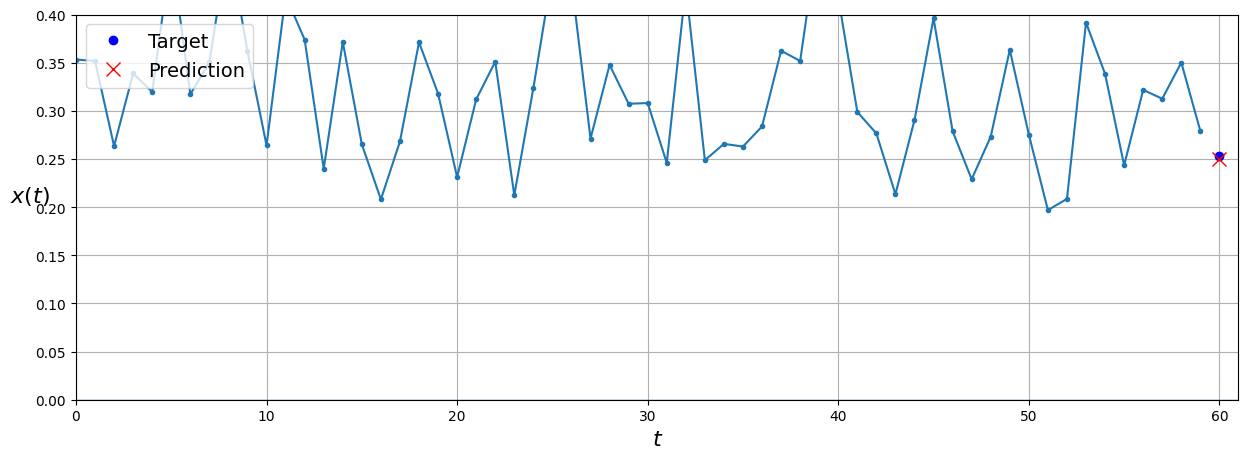

In [ ]:
y_p = model.predict(x_test)
plot_series(x_test[0, :, 0], y_test[0,0], y_p[0,0])

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="sgd")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = model.fit(x_train, y_train, epochs=50,      
                    validation_data=(x_test, y_test))

Epoch 1/50
20/20 [==============================] - 5s 91ms/step - loss: 0.0567 - val_loss: 0.0317
Epoch 2/50
20/20 [==============================] - 2s 107ms/step - loss: 0.0319 - val_loss: 0.0213
Epoch 3/50
20/20 [==============================] - 2s 125ms/step - loss: 0.0254 - val_loss: 0.0160
Epoch 4/50
20/20 [==============================] - 2s 122ms/step - loss: 0.0221 - val_loss: 0.0142
Epoch 5/50
20/20 [==============================] - 2s 97ms/step - loss: 0.0202 - val_loss: 0.0127
Epoch 6/50
20/20 [==============================] - 2s 93ms/step - loss: 0.0189 - val_loss: 0.0117
Epoch 7/50
20/20 [==============================] - 2s 83ms/step - loss: 0.0180 - val_loss: 0.0109
Epoch 8/50
20/20 [==============================] - 2s 98ms/step - loss: 0.0173 - val_loss: 0.0105
Epoch 9/50
20/20 [==============================] - 2s 111ms/step - loss: 0.0168 - val_loss: 0.0102
Epoch 10/50
20/20 [==============================] - 2s 122ms/step - loss: 0.0163 - val_loss: 0.0100
Epoc

8/8 [==============================] - 0s 16ms/step


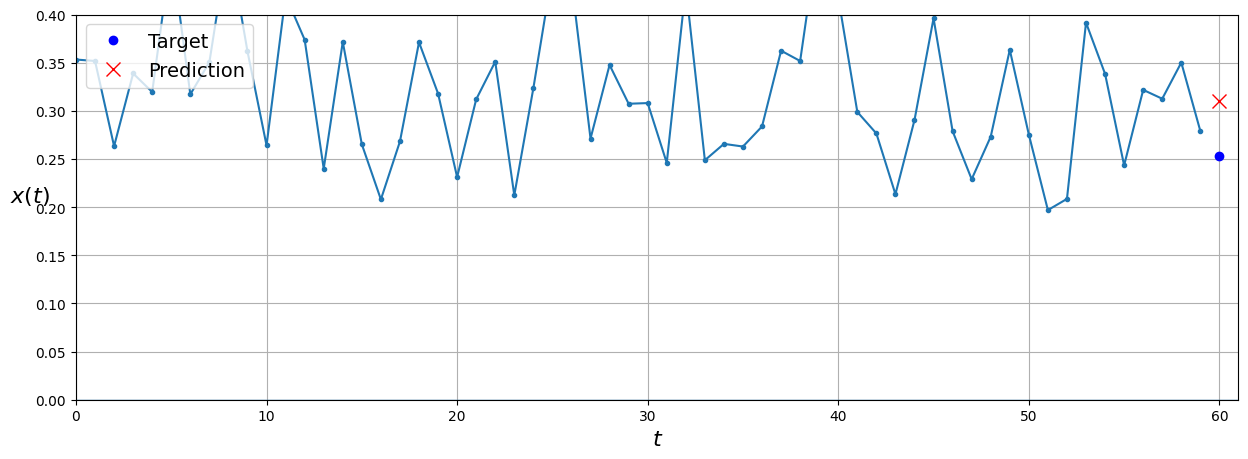

In [ ]:
y_p = model.predict(x_test)
plot_series(x_test[0, :, 0], y_test[0,0], y_p[0,0])

8/8 [==============================] - 0s 17ms/step - loss: 0.0069


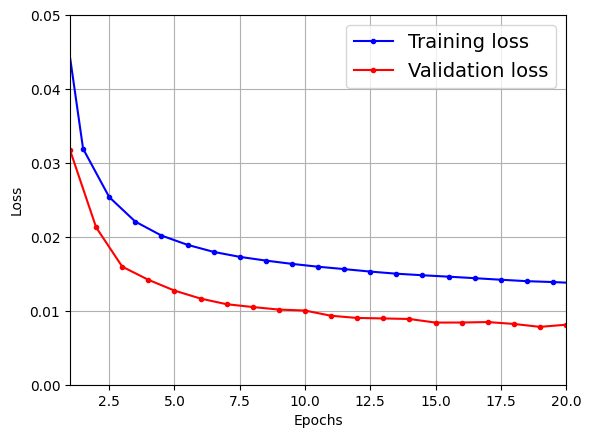

In [ ]:
model.evaluate(x_test, y_test)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

predicción de 10, uno a uno

In [ ]:

x_train, y_train = genera_muestras(df_train)
x_train[:][-1]
y_train
#print(len(y_train))
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_train.shape, y_train.shape


((618, 60, 1), (618, 10))

In [ ]:
x_test, y_test = genera_muestras(df_test)
x_test[:][-1]
y_test
#print(len(y_test))
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_test.shape, y_test.shape

((235, 60, 1), (235, 10))

In [ ]:
x = x_test
print(x.shape)
for h in range(10):
  y_predice_siguiente = model.predict(x)
  y_predice_siguiente = y_predice_siguiente[:, np.newaxis, :]
#  y_predice_siguiente = y_predice_siguiente.reshape(y_predice_siguiente[0], 1, 1)
  x = np.concatenate([x, y_predice_siguiente], axis=1)
print(x.shape)

(235, 60, 1)
8/8 [==============================] - 0s 11ms/step
(235, 70, 1)


In [ ]:
y_predichas = x[:, 60:]
y_predichas

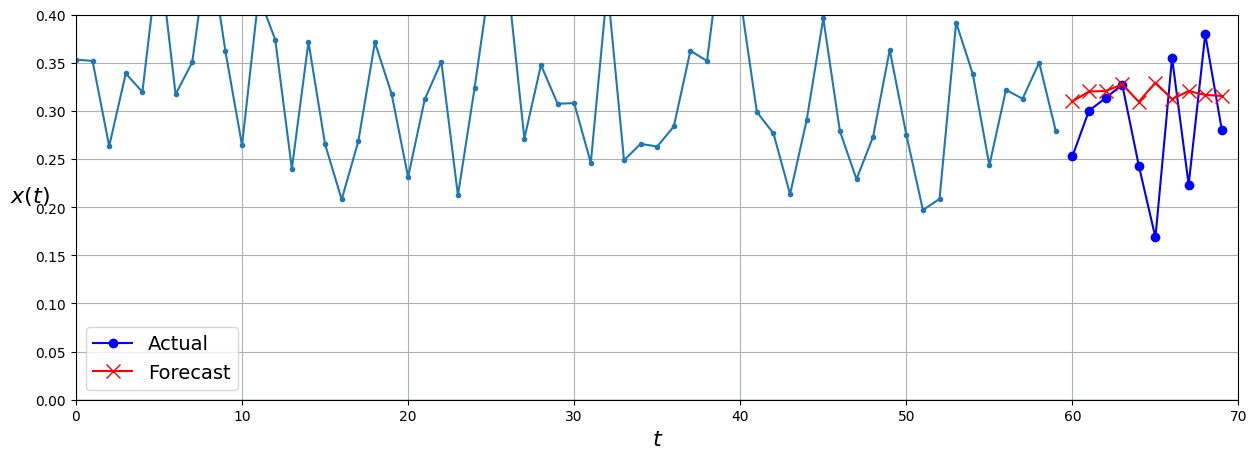

In [ ]:
plot_multiple_forecasts(x_test, y_test.reshape(y_test.shape[0], y_test.shape[1], 1), y_predichas)

predicción de 10, todos juntos

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(x_train, y_train, epochs=20,  validation_data=(x_test, y_test))



Epoch 1/20
20/20 [==============================] - 3s 47ms/step - loss: 0.1137 - val_loss: 0.0491
Epoch 2/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0583 - val_loss: 0.0342
Epoch 3/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0447 - val_loss: 0.0276
Epoch 4/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0377 - val_loss: 0.0243
Epoch 5/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0332 - val_loss: 0.0209
Epoch 6/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0301 - val_loss: 0.0195
Epoch 7/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0278 - val_loss: 0.0174
Epoch 8/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0259 - val_loss: 0.0165
Epoch 9/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0245 - val_loss: 0.0160
Epoch 10/20
20/20 [==============================] - 1s 53ms/step - loss: 0.0237 - val_loss: 0.0164
Epoch 11/

8/8 [==============================] - 0s 12ms/step


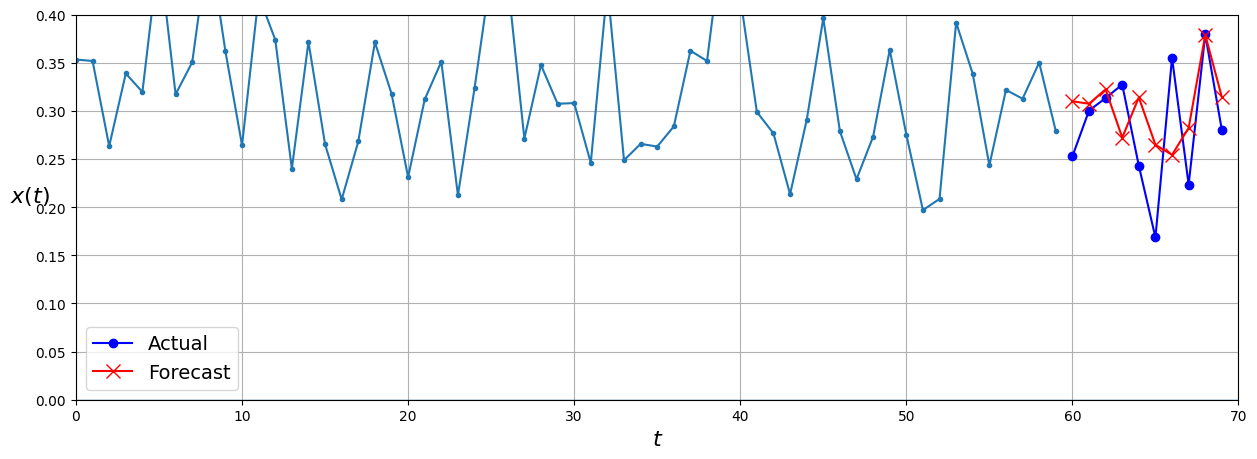

In [ ]:

y_pred = model.predict(x_test)[..., np.newaxis]
plot_multiple_forecasts(x_test, y_test.reshape(y_test.shape[0], y_test.shape[1], 1), y_pred)